In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Initialize Spark session with Hive support
spark = SparkSession.builder \
    .appName("Log Analysis in Jupyter") \
    .config("spark.sql.warehouse.dir", "hdfs://localhost:9000/user/hive/warehouse") \
    .enableHiveSupport() \
    .getOrCreate()

print("Spark Session Created!")

25/02/09 18:25:26 WARN Utils: Your hostname, riddhith-s-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.253.128 instead (on interface ens33)
25/02/09 18:25:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark Session Created!


In [6]:
df = spark.sql("SELECT * FROM server_logs_cleaned")
df.show(5)
df.printSchema()

+--------------------+---------+-----+-------------+--------+-------------+--------+-------+---------+-----+------+---+------+-----------+---------+------------------+
|     date_first_seen| duration|proto|       src_ip|src_port|       dst_ip|dst_port|packets|    bytes|flows| flags|tos| class|attack_type|attack_id|attack_description|
+--------------------+---------+-----+-------------+--------+-------------+--------+-------+---------+-----+------+---+------+-----------+---------+------------------+
|2017-03-14 17:43:...|81412.697|TCP  |   EXT_SERVER|    8082|OPENSTACK_NET|   56978|   3057|2100000.0|    1|.AP...|  0|normal|        ---|      ---|               ---|
|2017-03-14 17:43:...|81412.697|TCP  |OPENSTACK_NET|   56978|   EXT_SERVER|    8082|   4748|2500000.0|    1|.AP...|  0|normal|        ---|      ---|               ---|
|2017-03-14 17:43:...|81504.787|TCP  |   EXT_SERVER|    8082|OPENSTACK_NET|   56979|   8639|9100000.0|    1|.AP...|  0|normal|        ---|      ---|            

In [7]:
print("Total Rows:", df.count())

[Stage 7:>                                                          (0 + 1) / 1]

Total Rows: 172838


In [8]:
df.describe().show()

25/02/09 19:27:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 10:>                                                         (0 + 1) / 1]

+-------+--------------------+------------------+------+-------------+------------------+-------------+------------------+------------------+------------------+------+------+------+-------+-----------+---------+------------------+
|summary|     date_first_seen|          duration| proto|       src_ip|          src_port|       dst_ip|          dst_port|           packets|             bytes| flows| flags|   tos|  class|attack_type|attack_id|attack_description|
+-------+--------------------+------------------+------+-------------+------------------+-------------+------------------+------------------+------------------+------+------+------+-------+-----------+---------+------------------+
|  count|              172838|            172838|172838|       172838|            172838|       172838|            172838|            172838|            172838|172838|172838|172838| 172838|     172838|   172838|            172838|
|   mean|                NULL|136.29055911894469|  NULL|         NULL|22445.

In [9]:
from pyspark.sql.functions import col, count, when

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

[Stage 11:>                                                         (0 + 1) / 1]

+---------------+--------+-----+------+--------+------+--------+-------+-----+-----+-----+---+-----+-----------+---------+------------------+
|date_first_seen|duration|proto|src_ip|src_port|dst_ip|dst_port|packets|bytes|flows|flags|tos|class|attack_type|attack_id|attack_description|
+---------------+--------+-----+------+--------+------+--------+-------+-----+-----+-----+---+-----+-----------+---------+------------------+
|              0|       0|    0|     0|       0|     0|       0|      0|    0|    0|    0|  0|    0|          0|        0|                 0|
+---------------+--------+-----+------+--------+------+--------+-------+-----+-----+-----+---+-----+-----------+---------+------------------+



In [10]:
from pyspark.sql.functions import col, to_timestamp

df = df.withColumn("date_first_seen", to_timestamp(col("date_first_seen"), "yyyy-MM-dd HH:mm:ss.SSS"))
df.printSchema()

root
 |-- date_first_seen: timestamp (nullable = true)
 |-- duration: double (nullable = true)
 |-- proto: string (nullable = true)
 |-- src_ip: string (nullable = true)
 |-- src_port: string (nullable = true)
 |-- dst_ip: string (nullable = true)
 |-- dst_port: string (nullable = true)
 |-- packets: integer (nullable = true)
 |-- bytes: float (nullable = true)
 |-- flows: integer (nullable = true)
 |-- flags: string (nullable = true)
 |-- tos: integer (nullable = true)
 |-- class: string (nullable = true)
 |-- attack_type: string (nullable = true)
 |-- attack_id: string (nullable = true)
 |-- attack_description: string (nullable = true)



In [11]:
df_suspicious = df.filter(col("attack_type").isin(["400", "403", "500"]))
df_suspicious.show(10)

[Stage 14:>                                                         (0 + 1) / 1]

+---------------+--------+-----+------+--------+------+--------+-------+-----+-----+-----+---+-----+-----------+---------+------------------+
|date_first_seen|duration|proto|src_ip|src_port|dst_ip|dst_port|packets|bytes|flows|flags|tos|class|attack_type|attack_id|attack_description|
+---------------+--------+-----+------+--------+------+--------+-------+-----+-----+-----+---+-----+-----------+---------+------------------+
+---------------+--------+-----+------+--------+------+--------+-------+-----+-----+-----+---+-----+-----------+---------+------------------+



In [12]:
df_failed_requests = df_suspicious.groupBy("src_ip").count().orderBy(col("count").desc())
df_failed_requests.show(10)

[Stage 15:>                                                         (0 + 1) / 1]

+------+-----+
|src_ip|count|
+------+-----+
+------+-----+



In [13]:
from pyspark.sql.functions import window

df_traffic = df.groupBy(window(col("date_first_seen"), "1 hour")).count().orderBy("window")
df_traffic.show(10)

+--------------------+-----+
|              window|count|
+--------------------+-----+
|{2017-03-14 17:30...|   10|
|{2017-03-14 18:30...|    2|
|{2017-03-14 19:30...|    4|
|{2017-03-14 23:30...|  762|
|{2017-03-15 00:30...| 1266|
|{2017-03-15 01:30...| 1140|
|{2017-03-15 02:30...|  824|
|{2017-03-15 03:30...|  564|
|{2017-03-15 04:30...|  702|
|{2017-03-15 05:30...|  670|
+--------------------+-----+
only showing top 10 rows



Traffic Pattern Analysis
Goal: Understand network traffic over time and detect unusual spikes.
Actions:

Count requests per minute/hour/day to see traffic trends.
Identify peak traffic hours to detect anomalies.

Use Case: A sudden spike at unusual hours might indicate DDoS attacks or brute-force attempts.

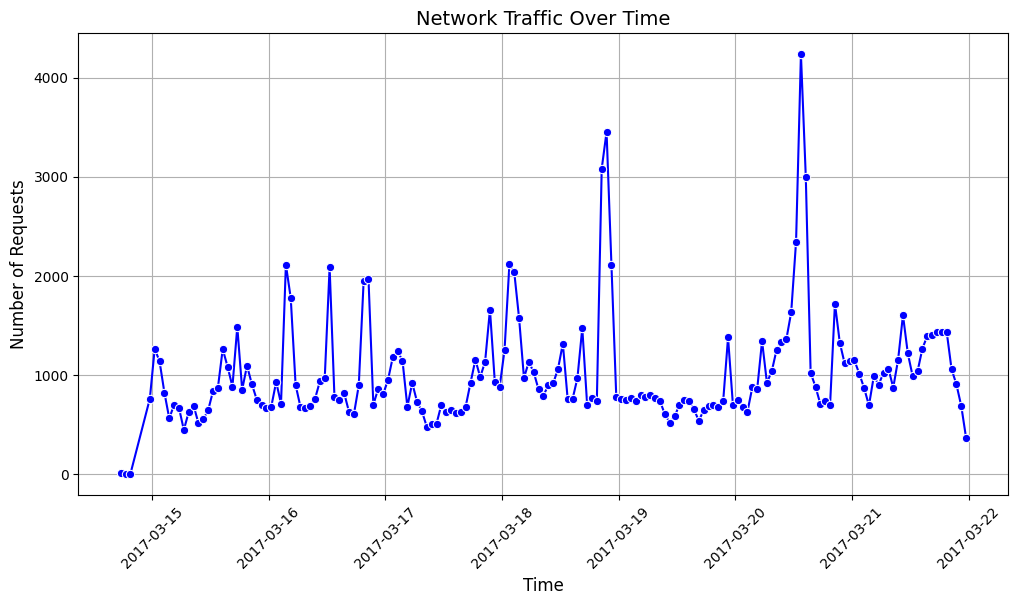

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Spark DataFrame to Pandas
df_traffic_pd = df_traffic.toPandas()

# Extract 'window' as string for proper plotting
df_traffic_pd["time"] = df_traffic_pd["window"].apply(lambda x: x.start)  # Extracting start time of window

# Sort data by time
df_traffic_pd = df_traffic_pd.sort_values(by="time")

# Plot the traffic trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_traffic_pd["time"], y=df_traffic_pd["count"], marker="o", linestyle="-", color="b")

# Formatting the plot
plt.xlabel("Time", fontsize=12)
plt.ylabel("Number of Requests", fontsize=12)
plt.title("Network Traffic Over Time", fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

Suspicious IP Analysis
Goal: Detect potential attackers based on high data transfers.
Find IPs transferring abnormally high amounts of data.

Use Case: If a single IP transfers massive data, it might be data exfiltration.

+-------------+------------+
|       src_ip|  sum(bytes)|
+-------------+------------+
|   EXT_SERVER|6.53698101E8|
|OPENSTACK_NET|1.62895765E8|
|     10006_27|   8725935.0|
|    10767_152|   8503100.0|
|     14105_47|   8243630.0|
|    12361_152|   8163309.0|
|    10320_204|   6900000.0|
|    14076_119|   3285280.0|
|    10320_208|   3127446.0|
|    10012_231|   3036042.0|
+-------------+------------+
only showing top 10 rows



/tmp/ipykernel_13978/1399751559.py:5: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pdf_heavy_traffic["src_ip"][:10], y=pdf_heavy_traffic["sum(bytes)"][:10], palette="Blues_r")


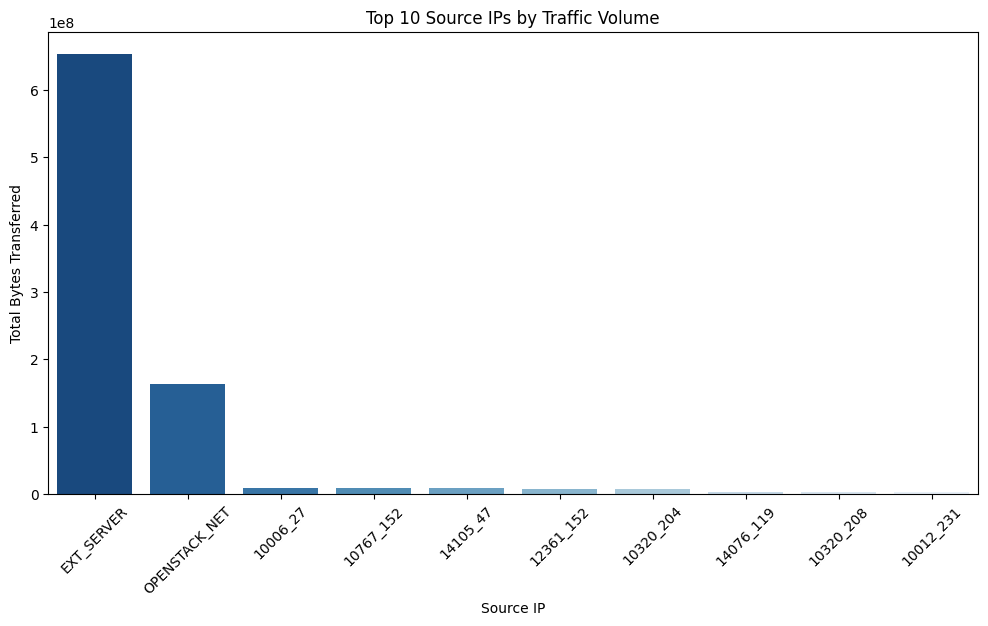

In [21]:
df_heavy_traffic = df.groupBy("src_ip").sum("bytes").orderBy(col("sum(bytes)").desc())
df_heavy_traffic.show(10)
pdf_heavy_traffic = df_heavy_traffic.toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x=pdf_heavy_traffic["src_ip"][:10], y=pdf_heavy_traffic["sum(bytes)"][:10], palette="Blues_r")
plt.xticks(rotation=45)
plt.xlabel("Source IP")
plt.ylabel("Total Bytes Transferred")
plt.title("Top 10 Source IPs by Traffic Volume")
plt.show()

Protocol Usage Analysis
Goal: Identify how different network protocols (TCP, UDP, etc.) are used.
📊 Actions:

Find the most used protocols.
Check if unusual protocols (e.g., ICMP) appear in logs.

Use Case: If rare protocols are appearing (like ICMP in high volume), it could indicate a covert attack.

In [22]:
df_protocol_usage = df.groupBy("proto").count()
df_protocol_usage.show()

[Stage 64:>                                                         (0 + 1) / 1]

+-----+------+
|proto| count|
+-----+------+
|GRE  |    37|
|TCP  |168800|
|UDP  |  2233|
|ICMP |  1768|
+-----+------+



/tmp/ipykernel_13978/1919479164.py:9: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pdf_protocol_usage["proto"], y=pdf_protocol_usage["count"], palette="viridis")


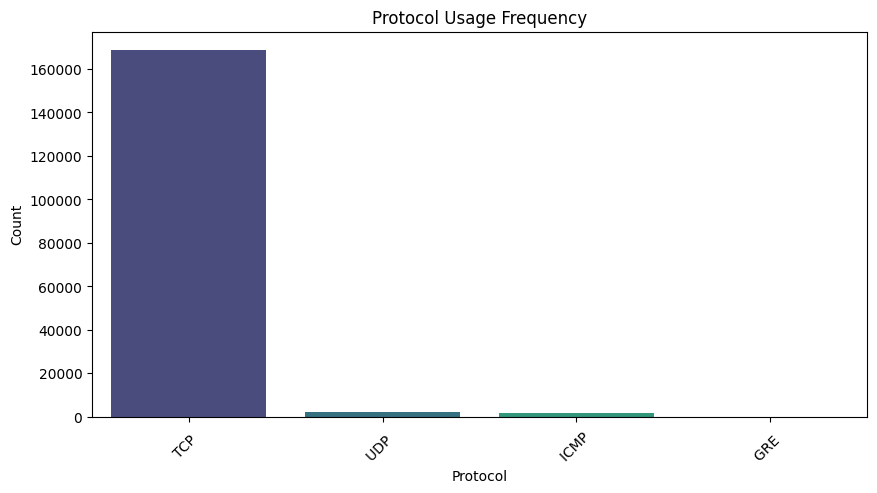

In [23]:
# Convert Spark DataFrame to Pandas
pdf_protocol_usage = df_protocol_usage.toPandas()

# Sort by count for better visualization
pdf_protocol_usage = pdf_protocol_usage.sort_values(by="count", ascending=False)

# Plot Bar Chart
plt.figure(figsize=(10, 5))
sns.barplot(x=pdf_protocol_usage["proto"], y=pdf_protocol_usage["count"], palette="viridis")

plt.xlabel("Protocol")
plt.ylabel("Count")
plt.title("Protocol Usage Frequency")
plt.xticks(rotation=45)
plt.show()

Port Scanning & Unusual Access
Goal: Detect port scanning attempts by checking multiple ports accessed by the same IP.
📊 Actions:

Find IPs accessing multiple ports.
Detect if the same IP is hitting multiple failed ports (e.g., scanning).

Use Case: If an IP is accessing too many unique ports, it may be running a port scan.

In [26]:
from pyspark.sql.functions import countDistinct
df_port_scanning = df.groupBy("src_ip").agg(countDistinct("dst_port").alias("unique_ports")).orderBy(col("unique_ports").desc())
df_port_scanning.show(10)

+----------+------------+
|    src_ip|unique_ports|
+----------+------------+
|EXT_SERVER|       41510|
| 10014_199|         294|
|  15359_42|         132|
| 10116_230|          94|
| 10184_168|          91|
| 11030_167|          67|
|  10982_72|          40|
| 10081_108|          39|
|  11242_55|          35|
|  10081_79|          31|
+----------+------------+
only showing top 10 rows



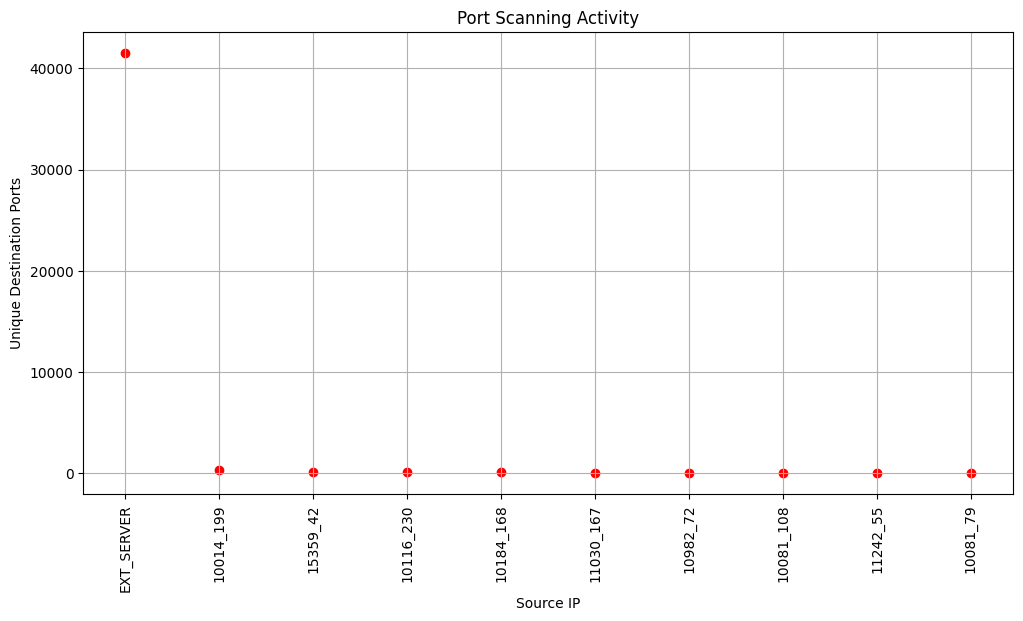

In [28]:
df_pandas = df_port_scanning.limit(10).toPandas()
plt.figure(figsize=(12, 6))
plt.scatter(df_pandas["src_ip"], df_pandas["unique_ports"], color="red")

# Labels
plt.xlabel("Source IP")
plt.ylabel("Unique Destination Ports")
plt.title("Port Scanning Activity")

plt.xticks(rotation=90)
plt.grid()

plt.show()

In [4]:
sc.stop()

NameError: name 'sc' is not defined